In [15]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import models as m

from sktime.datasets import load_from_tsfile_to_dataframe

In [16]:
CURR_DIR = Path.cwd()
CURR_DIR_PARENT = list(CURR_DIR.parents)
SRC_DIR = CURR_DIR_PARENT[0]

DATA_DIR = SRC_DIR / "data"
DATASET_DIR = DATA_DIR / "ECG5000"
train_path = DATASET_DIR / "ECG5000_TRAIN.ts"
test_path  = DATASET_DIR / "ECG5000_TEST.ts"

RUNS_DIR = CURR_DIR / "runs"

EXP_NAME = "ecg5000"

EXP_ROOT = RUNS_DIR / EXP_NAME
EXP_ROOT.mkdir(parents=True, exist_ok=True)

# On cherche les sous-dossiers numériques existants pour incrémenter l'ID
existing_ids = []
for p in EXP_ROOT.iterdir():
    if p.is_dir() and p.name.isdigit():
        existing_ids.append(int(p.name))

if len(existing_ids) == 0:
    next_id = 0
else:
    next_id = max(existing_ids) + 1

EXP_ID = str(next_id)
EXP_DIR = EXP_ROOT / EXP_ID
EXP_DIR.mkdir(parents=True, exist_ok=False)

print(f"Created new run: {EXP_NAME}/{EXP_ID}")
print("EXP_DIR:", EXP_DIR)

Created new run: ecg5000/0
EXP_DIR: /Users/rplanchon/Documents/MVA/Cours/S1/TimeSeries/Proj/T2SVEC/src/first_Imple/runs/ecg5000/0


## Load data

In [17]:
# X_train, X_test : DataFrame où chaque cellule contient une série numpy (dim == n_timesteps)
X_train, y_train = load_from_tsfile_to_dataframe(str(train_path))
X_test,  y_test  = load_from_tsfile_to_dataframe(str(test_path))

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Example series shape:", X_train.iloc[0, 0].shape)

# Convert to numpy arrays shape: (N, T, F)
def df_to_numpy(X):
    # Suppose univarié (F=1). Pour multivarié, concatène les colonnes.
    arr = np.stack([X.iloc[i, 0] for i in range(len(X))], axis=0)
    return arr[..., np.newaxis]  # (N, T, 1)

X_train_np = df_to_numpy(X_train)
X_test_np  = df_to_numpy(X_test)

X_train shape: (500, 1)
X_test shape : (4500, 1)
Example series shape: (140,)


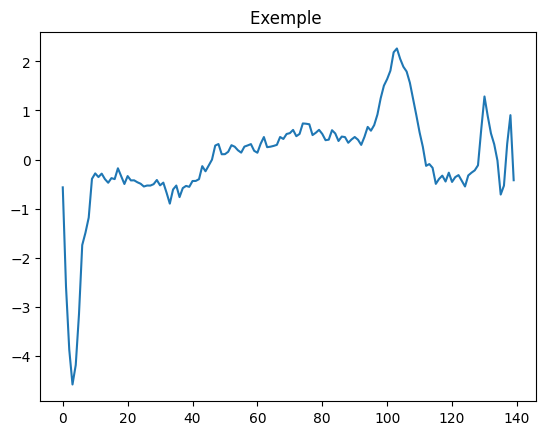

In [18]:
plt.figure()
plt.plot(X_train_np[2])
plt.title("Exemple ")
plt.show()

## Torch tensors + DataLoaders

In [19]:
X_train_torch = torch.from_numpy(X_train_np).float()
X_test_torch  = torch.from_numpy(X_test_np).float()
y_train_torch = torch.from_numpy(y_train.astype(np.int64))
y_test_torch  = torch.from_numpy(y_test.astype(np.int64))

# Dataset
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

BATCH_SIZE = 8  

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,     
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,    
    drop_last=False,
)

uuu = iter(train_loader)
x, y = next(uuu)
print( x.shape, y.shape)

torch.Size([8, 140, 1]) torch.Size([8])


## Losses (Instance / Time / Hierarchical)

In [20]:
def InstanceLoss(r1, r2):
    """
    r1, r2 : (B, K, T)
    Adaptation directe de instance_contrastive_loss de TS2Vec
    (qui attend (B, T, C)).
    """
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    if B == 1:
        # même logique : pas de contraste inter-instance possible
        return r1.new_tensor(0.)

    # on passe en (B, T, C) = (B, T, K)
    z1 = r1.permute(0, 2, 1)  # (B, T, K)
    z2 = r2.permute(0, 2, 1)  # (B, T, K)

    # --- copie quasi-littérale du code TS2Vec ---
    B, T, C = z1.size()
    z = torch.cat([z1, z2], dim=0)   # 2B x T x C
    z = z.transpose(0, 1)            # T x 2B x C
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B

    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
    # --- fin copie ---

    return loss


def TimeLoss(r1, r2):
    """
    r1, r2 : (B, K, T)
    Adaptation directe de temporal_contrastive_loss de TS2Vec
    (qui attend (B, T, C)).
    """
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    if T == 1:
        # pas de contraste temporel possible
        return r1.new_tensor(0.)

    # on passe en (B, T, C) = (B, T, K)
    z1 = r1.permute(0, 2, 1)  # (B, T, K)
    z2 = r2.permute(0, 2, 1)  # (B, T, K)

    # --- copie quasi-littérale du code TS2Vec ---
    z = torch.cat([z1, z2], dim=1)   # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T

    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2
    # --- fin copie ---

    return loss


def HierLoss(r1, r2, alpha: float = 0.5, temporal_unit: int = 0):
    """
    Version (B, K, T) de hierarchical_contrastive_loss.

    r1, r2 : (B, K, T)
    alpha : poids de l'instance loss vs time loss (comme TS2Vec)
    temporal_unit : profondeur minimale pour activer le time loss
    """
    assert r1.shape == r2.shape
    loss = r1.new_tensor(0.)
    d = 0

    # ici la dimension temporelle est r1.size(2)
    while r1.size(2) > 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        if d >= temporal_unit and (1 - alpha) != 0:
            loss += (1 - alpha) * TimeLoss(r1, r2)
        d += 1

        # pooling hiérarchique le long de T (dim=2) comme tu faisais
        r1 = F.max_pool1d(r1, kernel_size=2)  # (B, K, T//2)
        r2 = F.max_pool1d(r2, kernel_size=2)

    # niveau final T == 1 : seulement instance loss comme dans TS2Vec
    if r1.size(2) == 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        d += 1

    return loss / d

## Setup modèle, optim, hyperparams + sauvegarde config

In [21]:
import torch.optim as optim

if torch.cuda.is_available() : 
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else : 
    device = 'cpu'
    
print("Device:", device)

REP_DIM       = 320
NUM_BLOCKS    = 10
KERNEL_SIZE   = 3
LR            = 1e-4
N_EPOCH       = 500
ALPHA_HIER    = 0.5
TEMPORAL_UNIT = 0

model = m.Encoder(
    in_channel=1,
    representation_dim=REP_DIM,
    num_blocks=NUM_BLOCKS,
    kernel_size=KERNEL_SIZE,
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

# log des hyperparams pour pouvoir recharger
config = {
    "dataset": "ECG5000",
    "in_channel": 1,
    "representation_dim": REP_DIM,
    "num_blocks": NUM_BLOCKS,
    "kernel_size": KERNEL_SIZE,
    "lr": LR,
    "batch_size": BATCH_SIZE,
    "n_epoch": N_EPOCH,
    "alpha": ALPHA_HIER,
    "temporal_unit": TEMPORAL_UNIT,
    "use_instance_loss": True,
    "use_time_loss": True,
}

with open(EXP_DIR / "config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Config saved to", EXP_DIR / "config.json")

Device: mps
Config saved to /Users/rplanchon/Documents/MVA/Cours/S1/TimeSeries/Proj/T2SVEC/src/first_Imple/runs/ecg5000/0/config.json


## Training loop TS2Vec

In [ ]:
LogList = []

for epoch in range(N_EPOCH):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()

        # x : (B, T, 1)  to (B, 1, T)
        x = x.to(device).permute(0, 2, 1).contiguous()
        B, C, T = x.shape

        tau = np.random.random()
        L = int(tau * T)

        if L < 2:
            continue  

        # deux fenêtres [a1, a1+L], [a2, a2+L]
        a1 = np.random.randint(0, T - L + 1)
        a2 = np.random.randint(0, T - L + 1)
        end1 = a1 + L
        end2 = a2 + L
        
        # on calcule l’overlap dans la timeline globale
        inter_start = max(a1, a2)
        inter_end   = min(end1, end2)
        L_ov = inter_end - inter_start
        
        # pas de vraie overlap donc on saute ce batch
        if L_ov < 2:
            continue
        
        # offsets locaux dans chaque crop (dans la dimension temps)
        offset1 = inter_start - a1
        offset2 = inter_start - a2
        
        x1 = x[:, :, a1:end1]  # (B, 1, L)
        x2 = x[:, :, a2:end2]  # (B, 1, L)

        # passage dans le modèle
        r1 = model(x1)  # (B, K, L)
        r2 = model(x2)  # (B, K, L)
    
        # on tronque les représentations à la partie overlappée alignée
        r1_ov = r1[:, :, offset1:offset1+L_ov]  # (B, K, L_ov)
        r2_ov = r2[:, :, offset2:offset2+L_ov]  # (B, K, L_ov)

        # la HierLoss ne voit que la partie commune, alignée en t
        Loss = HierLoss(r1_ov, r2_ov, alpha=ALPHA_HIER, temporal_unit=TEMPORAL_UNIT)

        Loss.backward()
        optimizer.step()

        LogList.append(Loss.item())

    print(f"[Epoch {epoch+1}/{N_EPOCH}] Last batch loss: {Loss.item():.4f}")

    torch.save(model.state_dict(), EXP_DIR / "encoder.pt")

[Epoch 1/500] Last batch loss: 2.4238
[Epoch 2/500] Last batch loss: 1.6130
[Epoch 3/500] Last batch loss: 1.2319
[Epoch 4/500] Last batch loss: 1.3863
[Epoch 5/500] Last batch loss: 0.7042
[Epoch 6/500] Last batch loss: 0.6084
[Epoch 7/500] Last batch loss: 0.5836
[Epoch 8/500] Last batch loss: 1.6200
[Epoch 9/500] Last batch loss: 0.5593
[Epoch 10/500] Last batch loss: 1.0787
[Epoch 11/500] Last batch loss: 0.5579
[Epoch 12/500] Last batch loss: 0.4038
[Epoch 13/500] Last batch loss: 2.1181
[Epoch 14/500] Last batch loss: 0.2570
[Epoch 15/500] Last batch loss: 0.5330
[Epoch 16/500] Last batch loss: 0.2740
[Epoch 17/500] Last batch loss: 0.2525
[Epoch 18/500] Last batch loss: 0.4637
[Epoch 19/500] Last batch loss: 0.3273
[Epoch 20/500] Last batch loss: 0.4771
[Epoch 21/500] Last batch loss: 0.4906
[Epoch 22/500] Last batch loss: 1.5113
[Epoch 23/500] Last batch loss: 0.2709
[Epoch 24/500] Last batch loss: 0.2714
[Epoch 25/500] Last batch loss: 0.2354
[Epoch 26/500] Last batch loss: 0.

In [ ]:
# Sauvegarde de la loss + plot
Log_np = np.array(LogList, dtype=np.float32)
np.save(EXP_DIR / "train_loss.npy", Log_np)
print("Saved loss to", EXP_DIR / "train_loss.npy")

plt.figure()
plt.plot(Log_np)
plt.yscale("log")
plt.title("Training loss")
plt.xlabel("Iteration")
plt.ylabel("HierLoss")
plt.grid(True)
plt.savefig(EXP_DIR / "train_loss.png", bbox_inches="tight")
plt.show()

In [ ]:
total = sum(p.numel() for p in model.parameters())
print(f"Total params: {total/1e6:.2f} M")